# Sentiment analysis on Video Assistant Refereee(VAR) usage in worldcup 

## Twitter data acquisition 
Unique tweets are crawled from twitter on VAR

In [6]:
import tweepy
import csv
import pandas as pd
import unicodedata

#This file streams tweets from the Twitter API and saves them into a file 
#It will create a file with thousands of positive and negative tweets  

####input your credentials here
consumer_key = 'XXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXX'

#twitter crawler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

if (not api):
    print ("Problem Connecting to API")
    
#Maximum number of tweets we want to collect 
maxTweets = 30000


# filtering retweets
retweet_filter='-filter:retweets'
searchQuery = '#VAR'

tweetCount = 0



with open('tweet4.csv', 'a') as csvFile:
    csvWriter = csv.writer(csvFile)
    for tweet in tweepy.Cursor(api.search,q=searchQuery+retweet_filter,
                               lang="en",
                               since="2018-06-18", until = "2018-07-10").items(maxTweets):
        #print (tweet.created_at, tweet.text)
        if (not tweet.retweeted) and ('RT @' not in tweet.text):
            csvWriter.writerow([tweet.created_at, unicodedata.normalize('NFKD', tweet.text).encode('ascii','ignore')])
            tweetCount +=1
    #Display how many tweets we have collected
    print("Downloaded {0} tweets".format(tweetCount))

Downloaded 1194 tweets


## Storing the tweets in a text file

In [3]:
import pandas as pd
import glob
from datetime import date

columns = ['tweet_date', 'tweet']
data = pd.DataFrame()
csv_files = glob.glob('tweet*.csv')
for f in glob.glob('tweet*.csv'):
    df = pd.read_csv(f, header = None, names = columns)
    data = data.append(df, ignore_index= True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
#print(data.tail(5))
#tweet_text = data.iloc[:,1].apply(str)
#text = tweet_text.values
data['tweet_date'] =  pd.to_datetime(data['tweet_date'], format = '%d-%m-%Y %H:%M')
df = data.sort_values(by = 'tweet_date', ascending = True)
df = df.reset_index(drop = True)
text = df['tweet'].apply(str).values

# Preprocessing data
## Function to clean a tweet; remove the usernames, urls, numbers etc.

In [1]:
import re

# A list containing top most words which don't count towards sentiment analysis
f = open('datasets\stopwords.txt')
stopwords = f.read()
f.close
stopwords_2 = ['nan', 'var', 'football', 'URL', 'USER_MENTION', 'worldcup', 'worldcup2018','gerkor', 'kane', 'vs', 'tv', 'thats',
               'korger', 'mexswe', 'ngaarg', 'worldcuprussia2018','worldcup18', 'russia2018', 'fifaworldcup18', 'theres',
              'worldcup2018russia',' bbcworldcup', 'fifaworldcup']


def preprocess_word(word):
    word = word.strip('\'"?!,.():;') # Remove punctuation
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    word = re.sub(r'(-|\')', '', word) # Remove - & '
    return word

def hashtag(tweet):
    tweet = re.sub('#var', 'var', tweet)
    tweet = re.sub(r'#(\S+)','', tweet)
    return tweet
    
    
def preprocess_tweet(tweet):
    processed_tweet = []
    if tweet.startswith("b"):
        i = tweet.index('b')
        tweet = tweet[i+2:]
    
    
    tweet = tweet.lower()  # Convert to lower case    
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet) # Replaces URLs with the word URL    
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet) # Replace @handle with the word USER_MENTION    
    tweet = hashtag(tweet)
    #tweet = re.sub(r'#(\S+)', r' \1 ', tweet) # Replaces #hashtag with hashtag    
    tweet = re.sub(r'\brt\b', '', tweet) # Remove RT (retweet)    
    tweet = re.sub(r'\.{2,}', ' ', tweet) # Replace 2+ dots with space  
    tweet = tweet.strip(' "\'')   # Strip space, " and ' from tweet    
    tweet = re.sub(r'\s+', ' ', tweet) # Replace multiple spaces with a single space
    words = tweet.split()        
    
    for word in words:
        words = filter(lambda word: not word.isdigit(), words)
        word = preprocess_word(word)
        validity = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", word)
        if(validity is None):
            continue
        else:
            processed_tweet.append(word)
    return " ".join(processed_tweet)

In [4]:
filtered_tweet = []
processed_tweets = []
for tweet in text:
    filtered_tweet = preprocess_tweet(tweet)
    processed_tweets.append(filtered_tweet)

## Function to read the tweets from the file and convert it into a dictionary of words
## To find the most frequent words

In [5]:
from collections import Counter
d = {}
f = open('datasets\stopwords.txt')
stopwords = f.read()
f.close
stopwords_2 = ['nan','var', 'football', 'URL', 'USER_MENTION', 'worldcup', 'worldcup2018','thats', 'vs', 'tv',
               'korger','gerkor','mexswe', 'ngaarg', 'worldcuprussia2018','worldcup18', 'russia2018', 'fifaworldcup18',
              'russia2018worldcup',' bbcworldcup', 'fifaworldcup', 'fifaworldcup2018', 'argentinavsnigeria', 'worldcup2018russia']


for tweet in processed_tweets:
    words = tweet.strip().split()
    for word in words:
        if (word in stopwords )or(word in stopwords_2):
            continue 
        else:
            try:
                d[word] += 1
            except KeyError:
                d[word] = 1

data1 = Counter(d).most_common(15)
print('Fifteen most frequent words')
data1

Fifteen most frequent words


[('penalty', 1659),
 ('game', 817),
 ('world', 639),
 ('referee', 564),
 ('decision', 540),
 ('dont', 509),
 ('cup', 508),
 ('goal', 456),
 ('time', 392),
 ('penalties', 365),
 ('decisions', 339),
 ('team', 339),
 ('england', 315),
 ('referees', 287),
 ('love', 286)]

# Function to extract feauture vectors

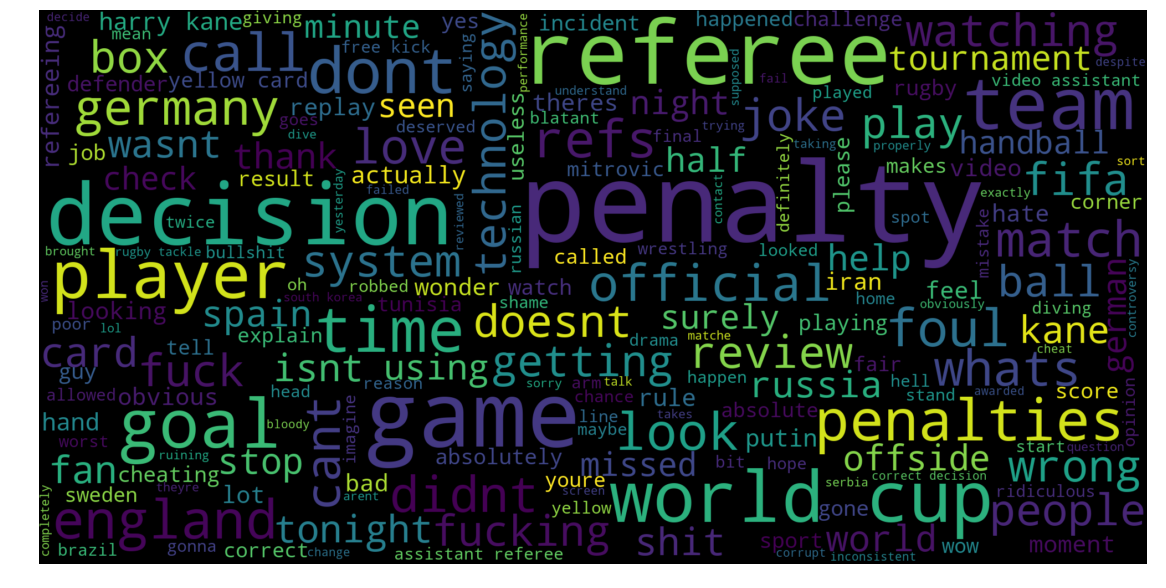

In [94]:
featureVector = []
for tweet in processed_tweets:
    words = tweet.strip().split()
    for word in words:
        if (word in stopwords )or(word in stopwords_2):
            continue 
        else: featureVector.append(word)         
from wordcloud import WordCloud
import matplotlib.pyplot as plt
featureVectors = pd.Series(featureVector).str.cat(sep=' ')
Word_cloud = WordCloud(width=2000, height=1000, max_font_size=200).generate(featureVectors)
plt.figure(figsize=(16,10))
plt.imshow(Word_cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Vader sentiment Analysis

In [6]:
# calculate Vadaer Sentiment scores - positive, negative and neutral
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
pos = []; neg = []; neu = []; compound = []
for tweet in processed_tweets:
    val = analyser.polarity_scores(tweet)
    pos.append(val['pos'])
    neg.append(val['neg'])
    neu.append(val['neu'])
    compound.append(val['compound'])

C:\Users\RAVIKUMAR\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# top 10 negative tweets

In [7]:
tweet_data = pd.DataFrame({'processed_tweets' : processed_tweets, 'pos' : pos, 'neg': neg, 'neu': neu, 'compound':compound})
tweet_data.sort_values(by = 'compound', ascending = True).head(10).style.set_properties(subset=['processed_tweets'], **{'width': '300px'})

,compound,neg,neu,pos,processed_tweets
4994,-0.9615,0.542,0.458,0,var is the right thing but theyre getting it so badly wrong so often theyre killing it
3622,-0.9473,0.622,0.378,0,valiant performance a loss but no shame in defeat unlucky to be denied by the var
5456,-0.9469,0.431,0.569,0,get rid of var immediately it has done nothing but encourage players to dive ruin the flow of the game worst URL
3424,-0.9413,0.497,0.503,0,this is bullshit this is big stinking fucking bullshit var will ruin football forever has just been han URL
7355,-0.9371,0.59,0.41,0,germans are always cheating total fraud fuck germany fuck i guess paid a lot for URL
445,-0.9345,0.563,0.437,0,absolutely raging the most ridiculous penalty decision of all time has fucked the bet var
3145,-0.9315,0.462,0.471,0.067,yes it was the right call but var is so shit absolute killer of the atmosphere
8445,-0.9313,0.465,0.535,0,var will be horrific on fifa standing up and delivering the dx suck it gesture whilst screaming obscenities at URL
6317,-0.9301,0.463,0.537,0,i dont like courts after criminals have killed that bad guy and gotten away they are caught and judged its URL
5309,-0.928,0.513,0.487,0,to hell with this var bullshit they must keep this shit away from club football


# Negative tweets Wordcount

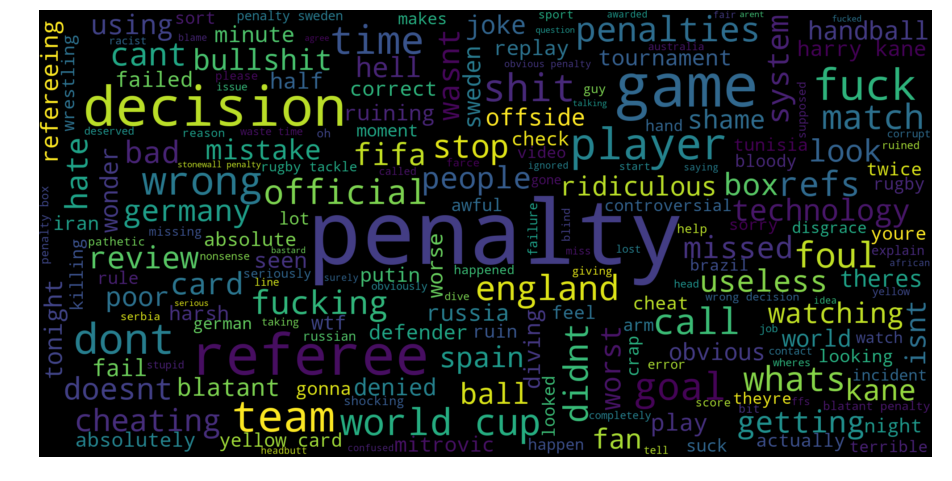

In [115]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
neg_featureVector = []
df1 = tweet_data[tweet_data['compound'] < -0.05 ]
neg_tweets = df1['processed_tweets'].values
for tweets_ in neg_tweets:
    words_ = tweets_.strip().split()
    for w in words_:
        if (w in stopwords )or(w in stopwords_2):
            continue 
        else: neg_featureVector.append(w)
neg_featureVectors = pd.Series(neg_featureVector).str.cat(sep=' ')
Word_cloud = WordCloud(width=2000, height=1000, max_font_size=200).generate(neg_featureVectors)
plt.figure(figsize=(16,10))
plt.imshow(Word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Score
As per Vader sentiment analysis given at https://github.com/cjhutto/vaderSentiment
 1) positive sentiment: compound score >= 0.05 
 2) neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
 3) negative sentiment: compound score <= -0.05

In [8]:
df_pos = tweet_data[tweet_data['compound'] > 0.05 ]
df_neu = tweet_data[(tweet_data['compound'] < 0.05) & (tweet_data['compound'] > -0.05) ]
df_neg = tweet_data[tweet_data['compound'] < -0.05 ]

print('total no of positive tweets on VAR is %d' %(len(df_pos)))
print('total no of negative tweets on VAR is %d' %(len(df_neg)))
print('total no of n tweets on VAR is %d' %(len(df_pos)))

total no of positive tweets on VAR is 4891
total no of negative tweets on VAR is 4837
total no of n tweets on VAR is 4891


# New columns according to the sentiment

In [155]:
import numpy as np
DF = df.join(tweet_data)
df_score = DF[['tweet_date','processed_tweets', 'compound']]
Score = df_score['compound'].values
Pos = np.where(Score > 0.05, 1, 0)
Neg = np.where(Score <-0.05, 1, 0)
Neu = np.where((Score > -0.05) &( Score < 0.05), 1, 0)
columns = ['Pos', 'Neg', 'Neu']
Score = pd.DataFrame(np.column_stack([Pos,Neg,Neu]), columns = columns)
tweet_sentiment_data = df_score.join(Score)
tweet_sentiment_data.head()

,tweet_date,processed_tweets,compound,Pos,Neg,Neu
0,2018-06-18 19:12:00,starting to feel bad for kane hes becoming a f...,-0.5423,0,1,0
1,2018-06-18 19:12:00,thats a high tackle and a yellow card in rugby...,0.0000,0,0,1
2,2018-06-18 19:12:00,var is working perfectly URL,0.6369,1,0,0
3,2018-06-18 19:12:00,im not one for conspiracy theories but there c...,0.6108,1,0,0
4,2018-06-18 19:12:00,being speared to the ground and no penalty var,-0.6369,0,1,0


# Visualisation

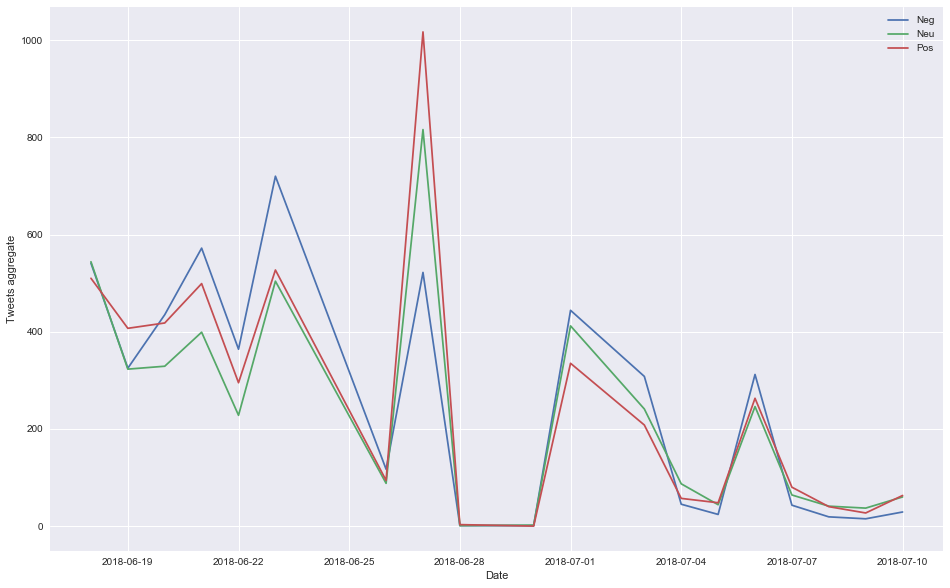

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
tweet_sentiment_data
tweet_sentiment_data['Date'] = tweet_sentiment_data['tweet_date'].dt.date
# creat pivottable
tweet_sentiment_data.pivot_table(['Pos', 'Neg', 'Neu'], index = 'Date', aggfunc= 'sum').plot(figsize = (16,10))
plt.ylabel('Tweets aggregate')
plt.show()